In [114]:
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import pytesseract
import mysql.connector
from mysql.connector import Error
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from skimage import io, color, morphology
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split



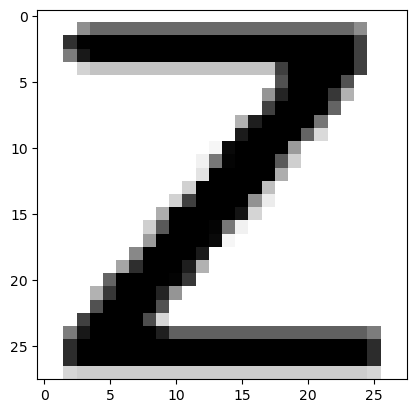

In [115]:

# Define paths
data_dir = 'C:/Users/Parth/Downloads/archive (4)/data/training_data'

# Initialize lists to hold image data and labels
images_data = []
labels = []
char_to_num = {chr(i): i - 65 for i in range(65, 91)}  # a-z to 0-25
char_to_num.update({str(i): i + 26 for i in range(10)})  # 0-9 to 26-35
# Iterate over each folder (0-9, a-z)
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            # Read the image in grayscale
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            img = cv2.resize(img, (28, 28))  # Resize to match the input shape of the CNN model
            images_data.append(img)
            labels.append(char_to_num[folder])
images_data = np.array(images_data, dtype='float32')
images_data = images_data / 255.0
images_data = images_data.reshape((images_data.shape[0], 28, 28, 1))
labels = np.array(labels, dtype="int")
# Create a dataframe with two columns: 'image' and 'label'
(azData, azLabels)=(images_data,labels)

x_train, x_test, y_train, y_test = train_test_split(azData, azLabels, test_size=0.2, random_state=42)

plt.imshow(img.squeeze(),cmap='gray')  # Remove single-dimensional entries from the shape


In [116]:
from tensorflow.keras import layers, models

model_alpha = models.Sequential([
    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Third Convolutional Layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolutional Layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    
    # Global Average Pooling
    layers.GlobalAveragePooling2D(),
    
    # Dense Layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(36, activation='softmax')  # For MNIST digits
])

model_alpha.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

# Train the model
history = model_alpha.fit(x_train, y_train, epochs=10, 
                        validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model_alpha.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.6206 - loss: 1.5256 - val_accuracy: 0.8919 - val_loss: 0.4042
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.9200 - loss: 0.2965 - val_accuracy: 0.9324 - val_loss: 0.2133
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9338 - loss: 0.2211 - val_accuracy: 0.9430 - val_loss: 0.1899
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9440 - loss: 0.1798 - val_accuracy: 0.9447 - val_loss: 0.1732
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.9530 - loss: 0.1524 - val_accuracy: 0.9348 - val_loss: 0.2096
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9557 - loss: 0.1374 - val_accuracy: 0.9389 - val_loss: 0.1822
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9610 - loss: 0.1216 - val_accuracy: 0.9460 - val_loss: 0.1747
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9648 - loss: 0.1115 - 

TypeError: Model.save() missing 1 required positional argument: 'filepath'

In [118]:
model_alpha.save('C:/Users/Parth/ocr.h5')

In [119]:
def straighten_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Apply Hough Line Transform to detect lines in the image
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    # Calculate the angle of the skew
    if lines is not None:
        angles = []
        for line in lines:
            rho, theta = line[0]
            angle = np.degrees(theta)
            if angle > 45:
                angle -= 90
            angles.append(angle)
        
        # Find the median angle of the lines detected
        skew_angle = np.median(angles)
    else:
        skew_angle = 0  # No lines detected, assume no skew

    # Get the dimensions of the image
    (h, w) = image.shape[:2]
    
    # Calculate the center of the image
    center = (w // 2, h // 2)
    
    # Calculate the rotation matrix to correct the skew
    M = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
    
    # Rotate the image to straighten it
    straightened = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return straightened

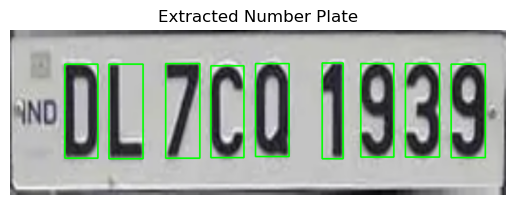

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
[1.19320925e-04 5.18951798e-03 1.19116623e-06 8.96404862e-01
 3.23078799e-04 1.21782512e-04 8.14066807e-05 7.85188973e-02
 2.08711252e-03 1.85109835e-04 1.30695174e-04 6.97976284e-05
 2.44515628e-04 1.96017837e-03 6.48123911e-04 7.49044633e-03
 1.39206066e-04 1.07362517e-03 3.04839068e-06 1.40031334e-04
 3.33858235e-03 1.70590560e-04 1.20287623e-04 2.71994886e-05
 3.30255602e-06 1.00141944e-04] 0 9
here


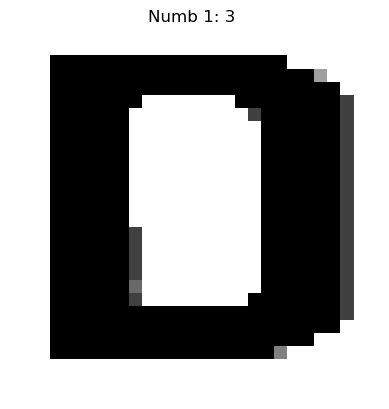

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[6.87273541e-06 2.74588183e-05 5.87330549e-04 1.46504435e-05
 2.16700276e-03 1.15842226e-06 3.59688397e-06 3.39054313e-05
 6.90890811e-05 9.76650085e-07 1.16849369e-04 9.95202780e-01
 1.26632522e-05 3.74113074e-06 4.30159645e-07 1.24329550e-03
 2.47839180e-05 6.80474113e-05 3.46785055e-05 3.89650722e-07
 1.08194581e-05 2.46488780e-05 1.36098976e-07 5.57456246e-07
 5.22970026e-07 2.25305237e-04] 1 9
here


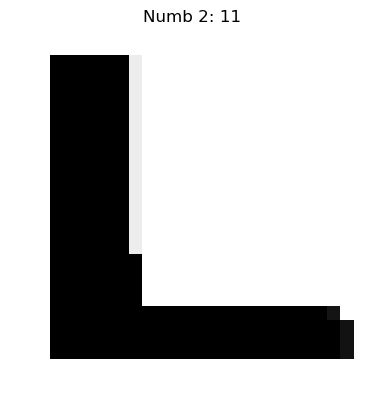

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[8.1440653e-12 1.6454213e-13 7.1450701e-12 5.4237630e-12 3.6994360e-14
 9.7486739e-09 2.1391762e-09 4.9210627e-12 3.1412113e-09 4.7577414e-10
 2.1051784e-11 3.5004450e-14 7.7668106e-12 7.1736506e-12 4.7719436e-11
 5.0140465e-12 5.4807135e-14 6.4678304e-14 2.8350171e-14 2.3579116e-08
 6.1149879e-12 5.2763433e-10 2.9673703e-13 6.1727512e-11 2.5975977e-09
 9.5326550e-06] 2 9
there


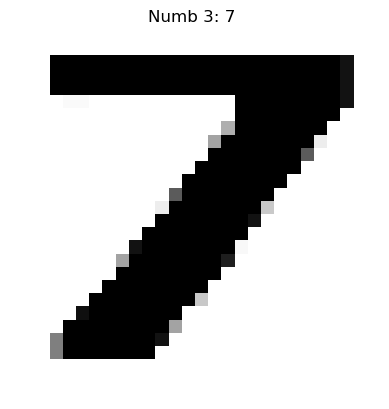

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[1.38194721e-07 1.83490886e-06 9.97387826e-01 3.95399138e-06
 8.41959729e-04 1.05229556e-04 6.09049283e-04 2.19554437e-07
 6.36538462e-05 6.72356975e-07 1.06381931e-05 7.85266384e-05
 4.75830610e-08 2.33294379e-08 5.24278767e-05 1.88765305e-04
 1.76074809e-06 2.45748311e-06 2.55840035e-07 5.83858171e-04
 1.29282341e-06 8.43839825e-06 5.51073782e-08 2.16214797e-08
 3.49052627e-08 2.05189172e-05] 3 9
here


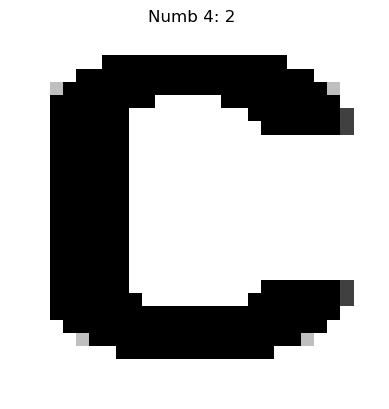

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[1.85168639e-04 2.25471331e-06 1.15619805e-04 3.31753872e-05
 1.35617029e-06 6.51099299e-07 8.93114411e-05 3.28494170e-05
 5.98390412e-04 1.30447434e-05 1.36486933e-05 1.61056050e-05
 2.63660263e-06 1.87431124e-05 5.94877987e-04 1.33441543e-04
 9.95375276e-01 1.05545297e-03 1.08905476e-06 1.04776427e-06
 9.61571641e-05 2.39846504e-05 8.23426149e-07 2.72828784e-05
 4.15884688e-06 2.90196999e-06] 4 9
here


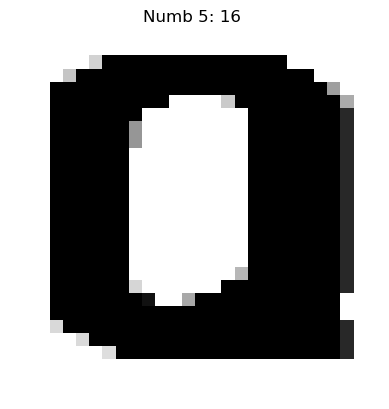

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[4.4091442e-09 2.6643496e-12 3.5028824e-12 1.1576944e-10 8.5088844e-14
 2.9234972e-09 5.8998822e-10 1.5932727e-08 6.4143651e-06 2.4648349e-08
 3.1341849e-11 1.7140471e-11 7.5926965e-10 4.7741325e-11 1.2045680e-07
 9.1234474e-13 1.4704838e-09 1.5410022e-11 1.6778579e-11 2.8666649e-05
 7.2012735e-10 3.9508996e-09 1.0694591e-11 3.2322749e-11 3.4120799e-08
 1.7804405e-12] 5 9
there


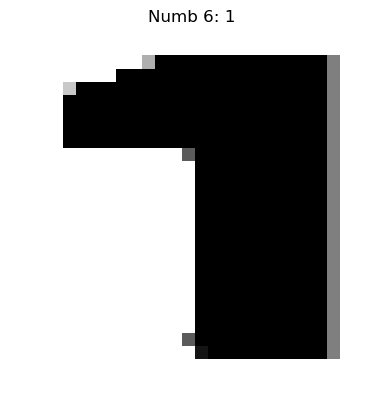

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[3.7661071e-08 3.5848285e-07 2.5810637e-08 6.0672426e-07 8.9215309e-06
 2.4757430e-06 3.1144224e-05 7.1260018e-08 8.3424435e-05 2.7283659e-06
 2.6442473e-09 1.0742665e-07 3.0422906e-09 6.1648009e-10 1.8647128e-05
 5.0261656e-07 4.9291295e-05 2.3683999e-08 1.5433611e-02 6.8139539e-06
 2.7262715e-08 1.7118292e-07 6.9594219e-10 2.7459262e-07 4.2514757e-06
 6.7130550e-08] 6 9
there


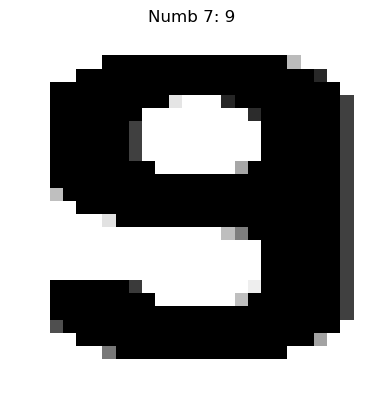

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[6.0116815e-07 1.9206348e-06 9.5991766e-09 3.8822883e-09 7.5570039e-09
 1.6707423e-07 4.5538591e-06 4.0454045e-09 1.2640504e-07 1.5954372e-06
 2.3477622e-09 8.7205825e-09 7.9987107e-11 1.1603771e-09 3.0348321e-08
 6.8554706e-10 1.1854113e-06 3.1603901e-07 2.7963972e-06 2.1747583e-08
 5.3772059e-10 2.6558444e-10 1.5442729e-10 1.6265703e-07 2.2151404e-08
 1.7942057e-06] 7 9
there


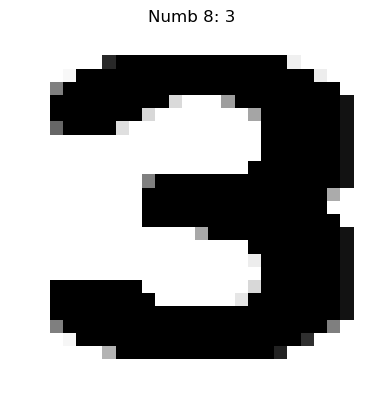

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[1.15810501e-07 3.65147429e-07 3.14994004e-08 1.18199500e-06
 7.45270563e-06 2.53594840e-06 1.59056563e-05 5.22399432e-07
 9.26962603e-05 1.53055571e-05 6.90007385e-09 2.25774301e-07
 1.96248653e-08 5.21095256e-09 2.02838819e-05 6.26761050e-07
 5.52651181e-05 2.28626238e-08 1.14659965e-02 5.37224332e-06
 1.28912617e-07 5.07441143e-07 2.37362041e-09 1.93414212e-06
 2.13997046e-05 3.98956217e-07] 8 9
there


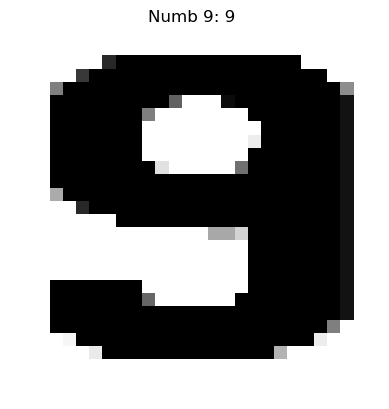

Recognized Text: DL7CQ1939
Recognized Text: 


In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def extract_and_segment_characters(image):
    # Convert to grayscale
#     image=cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blurring
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    
    # Get the bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Extract the number plate region
    number_plate = image[y:y+h, x:x+w]
    number_plate = straighten_image(number_plate)
    number_plate = cv2.resize(number_plate, (900, 300))
    
    # Convert the number plate region to grayscale
    number_plate_gray = cv2.cvtColor(number_plate, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to the number plate region
    thresh = cv2.adaptiveThreshold(number_plate_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)
    
    # Find contours in the thresholded number plate region
    char_contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on size and aspect ratio
    filtered_contours = []
    for contour in char_contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        if 0.2 < aspect_ratio < 1.0 and 1000 < cv2.contourArea(contour):
            filtered_contours.append((x,contour))
            cv2.rectangle(number_plate, (x, y), (x + w, y + h), (0, 255, 0), 2)
    filtered_contours.sort(key=lambda k: k[0])
    return number_plate, filtered_contours

def preprocess_char_img(char_img):
    if char_img.shape[-1] == 3:  # Check if the image has 3 channels (RGB)
        char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
    char_img = cv2.resize(char_img, (28, 28))  # Resize to match the input shape of the CNN model
    char_img = char_img / 255.0  # Normalize to [0, 1]
    char_img = np.expand_dims(char_img, axis=-1)  # Add channel dimension (28, 28, 1)
    char_img = np.expand_dims(char_img, axis=0)  # Add batch dimension (1, 28, 28, 1)
    return char_img

def predict(file_name):
    model_alpha=tf.keras.models.load_model('C:/Users/Parth/ocr.h5')
    image = cv2.imread(file_name)

    # Extract and segment characters
    number_plate, fc = extract_and_segment_characters(image)

    # Display the extracted number plate
    plt.imshow(cv2.cvtColor(number_plate, cv2.COLOR_BGR2RGB))
    plt.title('Extracted Number Plate')
    plt.axis('off')
    plt.show()


    recognized_text = ''
    recognized_text1 = ''

    char_contours=[]
    for i in  fc:
        char_contours.append(i[1])
    for i, contour in enumerate(char_contours):
        x, y, w, h = cv2.boundingRect(contour)
        char_img = number_plate[y-10:y+h+20, x-5:x+w+5]
        char_img = straighten_image(char_img)
        char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
    #     char_img = cv2.bitwise_not(char_img)
        _, char_img = cv2.threshold(char_img, 145, 255, cv2.THRESH_BINARY)
    #     char_img = morphology.skeletonize(char_img)
    #     char_img = (char_img * 255).astype(np.uint8)
    #     kernel = np.ones((3, 3), np.uint8)
    #     char_img = cv2.dilate(char_img, kernel, iterations=3)

        char_img = preprocess_char_img(char_img)  # Preprocess the character image
        # Predict the character using the CNN model
        prediction = model_alpha.predict(char_img)
        print(prediction[0][0:26],i,len(char_contours))
        f=0
        if ((0<=i<=1 or 4<=i<=5) and len(char_contours)==10) or ((0<=i<=1 or 3<=i<=4) and len(char_contours)==9):
            print('here')
            recognized_char_index = np.argmax(prediction[0][0:26])  # Get the index of the highest probability
        else:
            print('there')
            recognized_char_index = np.argmax(prediction[0][26:])
            f=1
    #     prediction1 = model_alpha.predict(char_img)
    #     recognized_char_index_1 = np.argmax(prediction1)
        # Assuming the model output indices correspond to characters 0-9 and A-Z
        if f==1:
            recognized_char = str(recognized_char_index)  # For digits 0-9
        else:
            recognized_char = chr(65 + recognized_char_index)  # For letters A-Z

        recognized_text += recognized_char if recognized_char else '?'
        #recognized_text1 += recognized_char1 if recognized_char1 else '?'

        # Display the character and its predicted label
        plt.imshow(char_img.squeeze(),cmap='gray')  # Remove single-dimensional entries from the shape
        plt.title(f'Numb {i+1}: {recognized_char_index} ')
        plt.axis('off')
        plt.show()

    print("Recognized Text:", recognized_text)
    print("Recognized Text:", recognized_text1)

predict('car.webp')

In [ ]:
print("Recognized Text:", recognized_text)